<a href="https://colab.research.google.com/github/Afsoon-Ghazanfari/DataScienceRoadmap/blob/main/5_Detecting_Spam_Emails_by_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Project

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
#Connecting to the Google Drive and creating dataframes
from google.colab import drive
drive.mount('/content/drive')

df=pd.read_csv('/content/drive/My Drive/emails.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


#Exploratory Data Analysis

In [3]:
df.shape

(5728, 2)

In [4]:
df.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
df.isnull().sum()

text    0
spam    0
dtype: int64

<Axes: xlabel='spam', ylabel='count'>

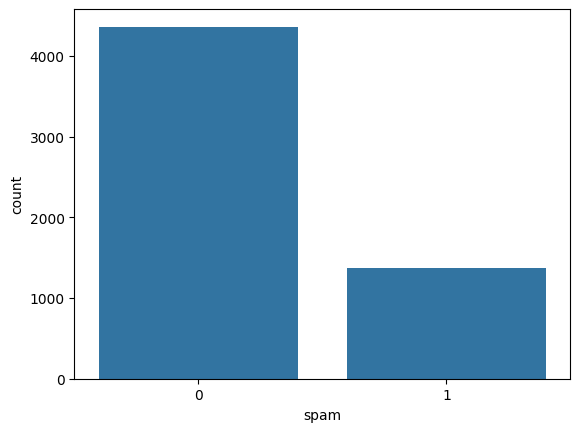

In [6]:
sns.countplot(df,x='spam')

Text(0.5, 1.0, 'Ham and Spam email after downsampling')

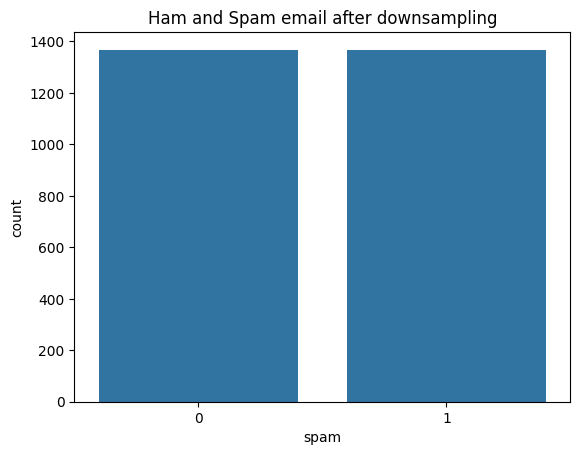

In [7]:
#It shows that the dataset is unbalansed
#Downsampling to balance the dataset
ham_msg=df[df['spam']==0]
spam_msg=df[df['spam']==1]

ham_msg=ham_msg.sample(n=len(spam_msg),random_state=42)

#Creating balance dataset
balanced_data=pd.merge(ham_msg, spam_msg, how='outer')

#Plotting the counts of down sampled dataset
sns.countplot(balanced_data,x='spam')
plt.title('Ham and Spam email after downsampling')

In [8]:
#Removing 'subject' from the text
balanced_data['text']=balanced_data['text'].str.replace('Subject','')
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [10]:
#Creating a function to remove punctuations
punctuations_list = string.punctuation
def remove_punctuation(text):
    text=''.join([word for word in text if word not in punctuations_list])
    return text

In [11]:
balanced_data['text']=balanced_data['text'].apply(lambda x:remove_punctuation(x))
balanced_data.head()

,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
#Creating a function to remove stop words
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text=' '.join([word for word in str(text).split() if word.lower() not in stop_words])
    return text

In [15]:
balanced_data['text']=balanced_data['text'].apply(lambda x:remove_stopwords(x))
balanced_data.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


#Visualisation

In [16]:
#Ploting a word cloud
#(text visualization tool that help’s us to get insights into the most frequent words present in the corpus )
def plot_word_cloud(data, typ):
  email_corpus=" ".join(data['text'])

  plt.figure(figsize=(8,8))
  wc=WordCloud(background_color='black', max_words=100, width=800, height= 400, collocations=False).generate(email_corpus)
  plt.imshow(wc, interpolation='bilinear')
  plt.title(f'WordCloud for {typ} emails', fontsize=15)
  plt.axis('off')
  plt.show()

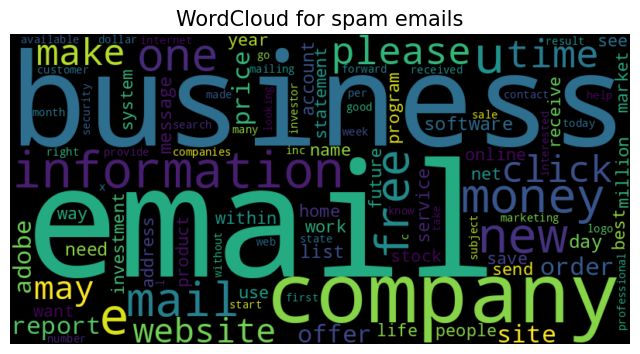

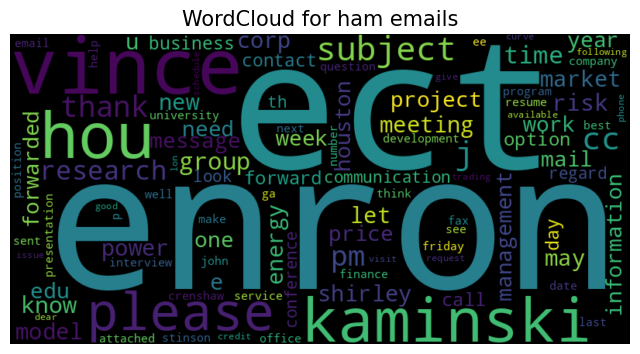

In [17]:
plot_word_cloud(balanced_data[balanced_data['spam']==1], typ='spam')
plot_word_cloud(balanced_data[balanced_data['spam']==0], typ='ham')

#Model Development

In [18]:
#Spliting our data
X=balanced_data['text']
y=balanced_data['spam']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#Converting words to vectors

# Tokenize the text data
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)


#Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences=pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [20]:
#Building the model
model = tf.keras.models.Sequential()
model.add(Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=32, input_length=max_len))
model.add(LSTM(16))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           805024    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808737 (3.09 MB)
Trainable params: 808737 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
#Creating callbacks
es = EarlyStopping(patience=3, monitor = 'val_accuracy', restore_best_weights = True)
lr = ReduceLROnPlateau(patience = 2, monitor = 'val_loss', factor = 0.5, verbose = 0)

In [23]:
#Training the model
history=model.fit(train_sequences, y_train, validation_data=(test_sequences, y_test), callbacks=[es,lr], epochs=20, batch_size=32)

Epoch 1/20
69/69 [==============================] - 7s 61ms/step - loss: 0.6723 - accuracy: 0.6330 - val_loss: 0.5915 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 4s 52ms/step - loss: 0.2577 - accuracy: 0.9310 - val_loss: 0.1417 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 5s 75ms/step - loss: 0.1053 - accuracy: 0.9785 - val_loss: 0.1354 - val_accuracy: 0.9690 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 4s 52ms/step - loss: 0.0558 - accuracy: 0.9890 - val_loss: 0.1287 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 3s 50ms/step - loss: 0.0869 - accuracy: 0.9813 - val_loss: 0.1210 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 4s 57ms/step - loss: 0.0504 - accuracy: 0.9904 - val_loss: 0.1307 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 5s 70ms/step - loss: 0.0

# Model Evaluation

In [24]:
train_loss, train_accuracy = model.evaluate(train_sequences, y_train)
print('Train Loss :',train_loss)
print('Train Accuracy :',train_accuracy)

69/69 [==============================] - 1s 10ms/step - loss: 0.0517 - accuracy: 0.9904
Train Loss : 0.05166279152035713
Train Accuracy : 0.9904022216796875


In [25]:
test_loss, test_accuracy = model.evaluate(test_sequences, y_test)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 [==============================] - 0s 11ms/step - loss: 0.1210 - accuracy: 0.9745
Test Loss : 0.12104978412389755
Test Accuracy : 0.974452555179596


In [26]:
history.history

{'loss': [0.6723039746284485,
  0.2576528489589691,
  0.10525374114513397,
  0.05578707531094551,
  0.08690425008535385,
  0.05035270377993584,
  0.03559568151831627,
  0.02751190774142742],
 'accuracy': [0.6329981684684753,
  0.9309871792793274,
  0.9785192012786865,
  0.9890310764312744,
  0.9812614321708679,
  0.9904022216796875,
  0.9936014413833618,
  0.9954296350479126],
 'val_loss': [0.5915310978889465,
  0.14174194633960724,
  0.1354179084300995,
  0.12867124378681183,
  0.12104978412389755,
  0.1307341456413269,
  0.12852902710437775,
  0.13074633479118347],
 'val_accuracy': [0.779197096824646,
  0.9671533107757568,
  0.9689781069755554,
  0.970802903175354,
  0.974452555179596,
  0.9726277589797974,
  0.974452555179596,
  0.974452555179596],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0005]}

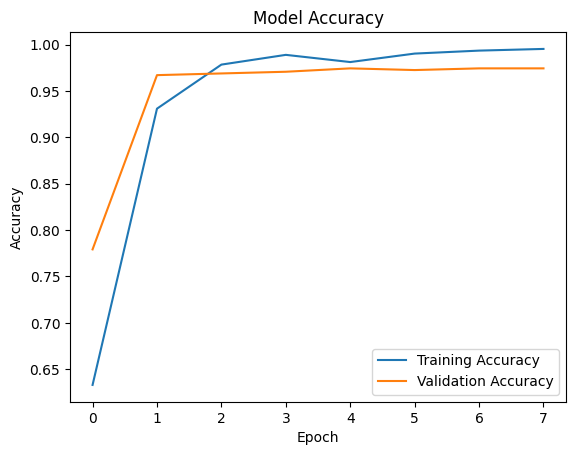

In [27]:
#Ploting the model accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#plt.ylim(0.9, 1)
#plt.xlim(0, 10)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()